# Imports

In [1]:
%load_ext autoreload
%autoreload 2

from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from paperfig import *
import pickle

from util import get_spectra_cuts, best_linear_fit_model, best_linear_fit_model_simultaneous

set_fontscale(2.0)
light_speed = 299792.458  # speed of light in km/s

In [2]:
disperser = "G140"
filter = "F100LP"

mode = "IFS"

save_output = True

In [3]:
repopulate_line_lists = True
aggregate_he_lines_window = 0.4  # in AA

In [4]:
# from https://linelist.pa.uky.edu/newpage/

widths = [18, 11, 4, 25, 20, 10, 9, 6, 29, 7]
column_names = [
    "lambda_vac",
    "species",
    "TT",
    "TERM",
    "J_i-J_k",
    "A_ki",
    "gk*Aki",
    "TPF",
    "LEVEL-ENERGY--CM^-1",
    "REF",
]

line_list = pd.read_fwf(
    "./data/line_atlas.txt",
    widths=widths,
    names=column_names,
    header=None,
    skiprows=1,
)

line_list

,lambda_vac,species,TT,TERM,J_i-J_k,A_ki,gk*Aki,TPF,LEVEL-ENERGY--CM^-1,REF
0,4542.864000,He II,E1,4-9,1/2-7/2 - 1/2-17/2,1194000.0,1.934000e+08,28,411477.95 - 433490.48,007
1,4687.020000,He II,E1,3-4,1/2-5/2 - 1/2-7/2,143800000.0,4.603000e+09,28,390142.40 - 411477.95,007
2,4714.457832,He I,E1,3Po-3S,2 - 1,5290000.0,1.587000e+07,31,169086.77 - 190298.11,112
3,4714.474819,He I,E1,3Po-3S,1 - 1,3170000.0,9.510000e+06,31,169086.84 - 190298.11,112
4,4714.694406,He I,E1,3Po-3S,0 - 1,1060000.0,3.180000e+06,31,169087.83 - 190298.11,112
...,...,...,...,...,...,...,...,...,...,...
9995,59073.728008,He I,E1,3Fo-3D,2 - 1,8450.0,2.535000e+04,31,195262.43 - 196955.23,112
9996,59073.784434,He I,E1,3Fo-3D,2 - 2,939.0,4.695000e+03,31,195262.43 - 196955.23,112
9997,59073.788438,He I,E1,3Fo-3D,2 - 3,19.2,1.344000e+02,31,195262.43 - 196955.23,112
9998,59073.903481,He I],E1,1Fo-3D,3 - 2,1960.0,9.800000e+03,31,195262.43 - 196955.23,112


# Load datacube

/var/folders/bn/g_64xdl56nj_f4wtmm1_bk9h0000gn/T/ipykernel_19581/1744782321.py:65: RuntimeWarning: divide by zero encountered in log10
  np.log10(white_light_image),


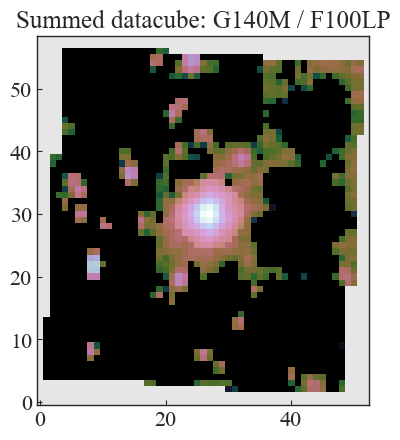

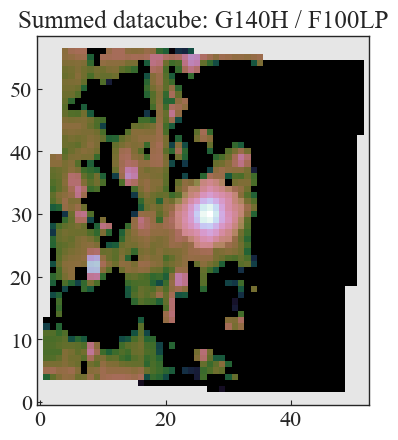

In [ ]:
disperser = disperser.lower()
filter = filter.lower()

spectra_1d_both = []
wavelengths_both = []
noise_1d_both = []

for res_string in ["M", "H"]:
    if mode == "IFS":

        file_name = f"./large_data/nirspec/ifs/jw01492-o008_t001_nirspec_{disperser}{res_string.lower()}-{filter}_s3d.fits"

        cube, header = fits.getdata(
            file_name,
            header=True,
            ext=1,
        )

        noise = fits.getdata(
            file_name,
            ext=2,
        )

        dq = fits.getdata(
            file_name,
            ext=3,
        )

        cube[dq != 0] = np.nan

        wavelengths = (
            header["CRVAL3"] + header["CDELT3"] * np.arange(header["NAXIS3"])
        ) * 1e4

        radius = 5.5
        max_x, max_y = 27, 30

        # make circular mask
        x = np.arange(cube.shape[2])
        y = np.arange(cube.shape[1])
        xx, yy = np.meshgrid(x, y)
        mask = (xx - max_x) ** 2 + (yy - max_y) ** 2 < radius**2

        spectra_1d = np.nansum(cube[:, mask], axis=1)
        noise_1d = np.sqrt(
            np.nansum(
                noise[:, mask] ** 2,
                axis=1,
            )
        )

        # plot the box within which the spectra is summed
        white_light_image = np.nansum(cube, axis=0)
        white_light_image = np.nan_to_num(
            white_light_image, nan=1e-6, posinf=1e-6, neginf=1e-6
        )

        white_light_image[white_light_image < 0] = np.min(
            white_light_image[white_light_image > 0]
        )

        plt.figure()

        plt.imshow(
            np.log10(white_light_image),
            origin="lower",
            cmap="cubehelix",
            interpolation=None,
        )

        # plot block outline around mask pixels

        plt.imshow(
            mask,
            origin="lower",
            cmap="cubehelix",
            vmin=0,
            vmax=1,
            alpha=0.1,
        )

        plt.title(
            f"Summed datacube: {disperser.upper()}{res_string.upper()} / {filter.upper()}"
        )
        plt.show()

        spectra_1d_both.append(spectra_1d)
        wavelengths_both.append(wavelengths)
        noise_1d_both.append(noise_1d)

    elif mode == "FS":
        if res_string == "M":
            file_name = f"./large_data/nirspec/fs/jw01125-o001_s000000001_nirspec_{filter}-{disperser}m-s200a1-subs200a1_x1d.fits"
            # file_name = f"./large_data/nirspec/fs/jw01492-o001_s000000001_nirspec_{filter}-{disperser}m-s200a1-subs200a1_x1d.fits"
        elif res_string == "H":
            file_name = f"./large_data/nirspec/fs/jw01125-o001_s000000001_nirspec_{filter}-{disperser}h-s200a1-subs200a1_x1d.fits"
            # file_name = f"./large_data/nirspec/fs/jw01492-o001_s000000001_nirspec_{filter}-{disperser}h-s200a1-subs200a1_x1d.fits"

        data = Table.read(
            file_name,
            hdu=1,
        )

        print(f"Rows: {len(data)}, Columns: {len(data.colnames)}")

        spectra_1d = np.array(data["FLUX"])
        noise_1d = np.array(data["FLUX_ERROR"])
        wavelengths = np.array(data["WAVELENGTH"])
        wavelengths *= 1e4  # convert to Angstroms

        spectra_1d_both.append(spectra_1d)
        wavelengths_both.append(wavelengths)
        noise_1d_both.append(noise_1d)
    elif mode == "MSA":
        if res_string == "M":
            file_name = f"./large_data/nirspec/fs/jw01125-o001_s000000001_nirspec_{filter}-{disperser}m-s200a1-subs200a1_x1d.fits"
        elif res_string == "H":
            file_name = f"./large_data/nirspec/msa/jw01125-o005_s000005329_nirspec_{filter}-{disperser}h_x1d.fits"

        data = Table.read(
            file_name,
            hdu=1,
        )

        print(f"Rows: {len(data)}, Columns: {len(data.colnames)}")

        # spectra_1d = np.array([a[1] for a in data])
        # noise_1d = np.array([a[2] for a in data])
        # wavelengths = np.array([a[0] for a in data])
        # wavelengths *= 1e4
        spectra_1d = np.array(data["FLUX"])
        noise_1d = np.array(data["FLUX_ERROR"])
        wavelengths = np.array(data["WAVELENGTH"])
        wavelengths *= 1e4  # convert to Angstroms

        spectra_1d_both.append(spectra_1d)
        wavelengths_both.append(wavelengths)
        noise_1d_both.append(noise_1d)

first_nonzero = np.where(spectra_1d_both[1] > 0)[0][0]
last_nonzero = np.where(spectra_1d_both[1] > 0)[0][-1]

nonzero_wavelengths = wavelengths_both[1][first_nonzero:last_nonzero]
lambda_pivot = np.sqrt(nonzero_wavelengths[0] * nonzero_wavelengths[-1])

In [6]:
np.mean(np.diff(wavelengths_both[0])) / np.mean(
    np.diff(wavelengths_both[1])
)  # , axis=1)

np.float64(2.706383033531894)

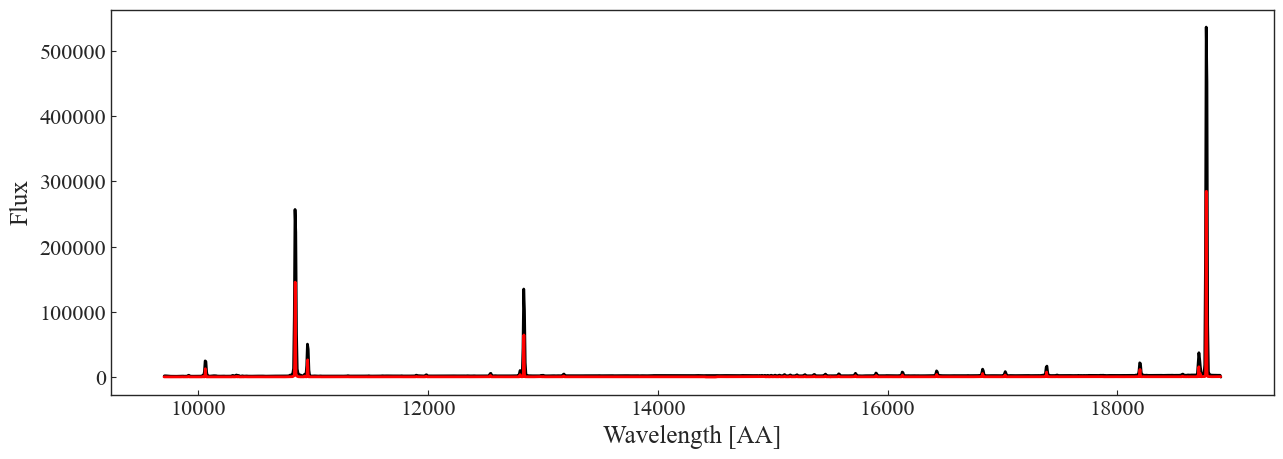

In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)
ax.plot(
    wavelengths_both[0],
    spectra_1d_both[0],
    color="black",
    lw=2,
)
ax.plot(
    wavelengths_both[1],
    spectra_1d_both[1]/5,
    color="red",
    lw=2,
)

ax.set_xlabel("Wavelength [AA]")
ax.set_ylabel("Flux")
plt.show()

In [8]:
from spec_slice import get_spectra_slice_specs

spectra_slices = get_spectra_slice_specs(
    disperser=disperser,
    mode=mode,  # "IFS"  # "MSA" if mode == "FS" else mode
    extend=True if filter == "f070lp" else False,
)

if repopulate_line_lists:
    for spectra_slice in spectra_slices:
        min_lambda = spectra_slice["min_lambda"]
        max_lambda = spectra_slice["max_lambda"]

        line_list_slice = line_list[
            (line_list["lambda_vac"] > min_lambda / (1 + 200 / light_speed))
            & (line_list["lambda_vac"] < max_lambda / (1 + 400 / light_speed))
        ]

        # group lines that are within 0.1 AA of each other
        line_wavelengths = []
        line_names = []

        # include H lines and remove from line_list_slice
        for _, line in line_list_slice.iterrows():
            if "H I" in line["species"]:
                line_wavelengths.append(line["lambda_vac"])
                line_names.append(line["species"])

        line_list_slice = line_list_slice[
            ~line_list_slice["species"].str.contains("H I")
        ]

        start_point = 0
        while start_point < len(line_list_slice):
            # find index in line_list_slice where the next line is more than 0.1 AA away
            index_end = start_point + 1
            while (
                index_end < len(line_list_slice)
                and line_list_slice.iloc[index_end]["lambda_vac"]
                - line_list_slice.iloc[start_point]["lambda_vac"]
                < 0.4
            ):
                index_end += 1

            # average line wavelengths weighted g_k * A_ki
            line_wavelengths.append(
                np.average(
                    line_list_slice.iloc[start_point:index_end]["lambda_vac"],
                    weights=line_list_slice.iloc[start_point:index_end]["gk*Aki"],
                )
            )
            line_names.append(line_list_slice.iloc[start_point]["species"])

            start_point = index_end

        spectra_slice["line_names"] = line_names
        spectra_slice["line_wavelengths"] = line_wavelengths

num_lines = len(spectra_slices)

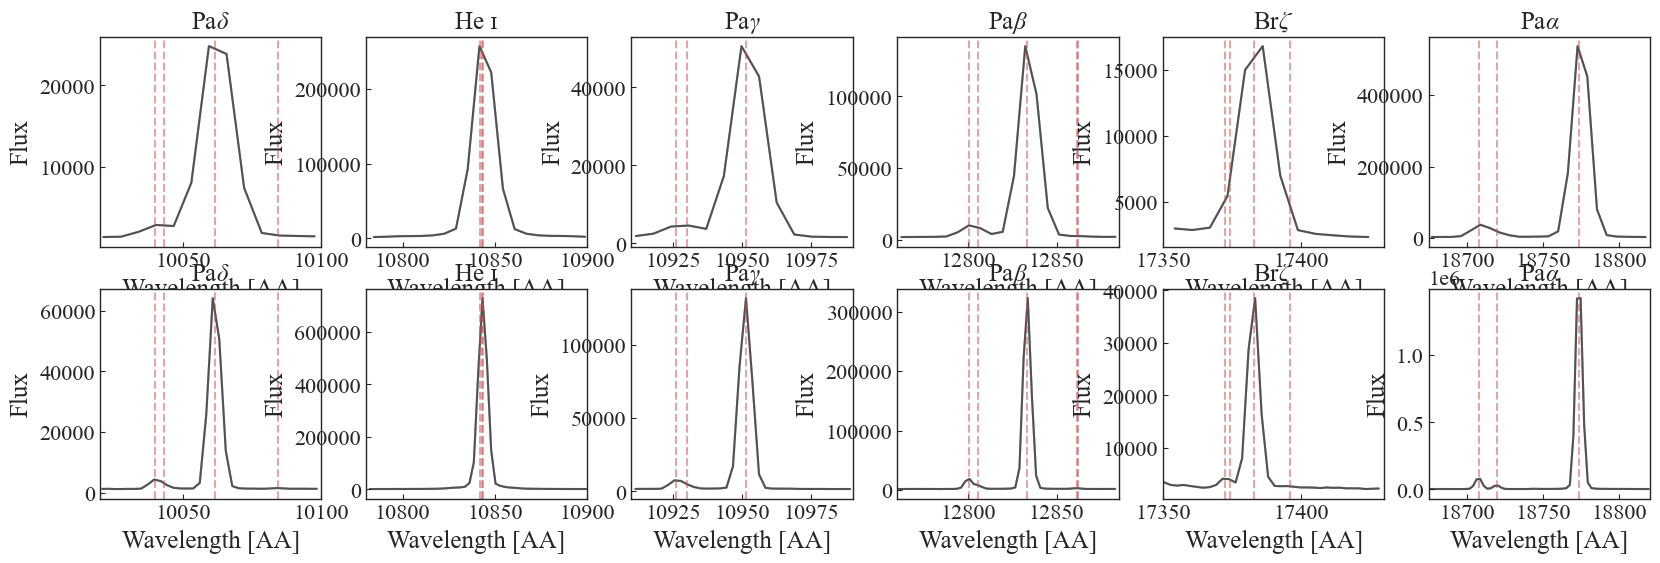

In [ ]:
fig, axes = plt.subplots(2, num_lines, figsize=(20, 1 * num_lines))

for i in range(num_lines):
    line_spec = spectra_slices[i]

    min_lambda = line_spec["min_lambda"]
    max_lambda = line_spec["max_lambda"]
    main_line_name = line_spec["main_line_name"]
    line_wavelengths = line_spec["line_wavlengths"]

    z_target = 278 / light_speed

    # ax.step(wavelengths / (1 + z_target), spectra_1d, where="mid")
    for j in range(2):
        wavelength_cut, spectra_cut, noise_cut = get_spectra_cuts(
            min_lambda,
            max_lambda,
            wavelengths_both[j],
            spectra_1d_both[j],
            noise_1d_both[j],
        )
        axes[j, i].plot(wavelength_cut, spectra_cut, color="k", alpha=0.5)
        axes[j, i].plot(wavelength_cut, spectra_cut, color="k", alpha=0.5)

        for line_wavelength in line_wavelengths:
            line_wavelength *= 1 + z_target

            axes[j, i].axvline(line_wavelength, color="r", linestyle="--", alpha=0.5)

        axes[j, i].set_xlabel("Wavelength [AA]")
        axes[j, i].set_ylabel("Flux")
        axes[j, i].set_xlim(line_spec["min_lambda"], line_spec["max_lambda"])

        axes[j, i].set_title(main_line_name)

    fwhm_init = 11 / 2.7  # AA

# fig

## Fit a model

In [ ]:
from scipy.stats import norm
from nautilus import Prior
import paperfig as pf

add_wavelength_error = False
add_fwhm_scatter = False

prior = Prior()

prior.add_parameter("velocity_m", dist=(230, 330))
prior.add_parameter("R_m", dist=(50, 200))
prior.add_parameter("alpha_m", dist=(-3, 3))

prior.add_parameter("velocity_h", dist=(230, 330))
prior.add_parameter("R_h", dist=(10, 100))
prior.add_parameter("alpha_h", dist=(-3, 3))

pn_sigma_mean = 6.90  # in km/s
pn_sigma_sigma = 0.49  # in km/s


wavelength_cuts = [[], []]
spectra_cuts = [[], []]
noise_cuts = [[], []]
line_lists = []
main_line_names = []

for i in range(num_lines):
    line_spec = spectra_slices[i]

    min_lambda = line_spec["min_lambda"]
    max_lambda = line_spec["max_lambda"]
    main_line_name = line_spec["main_line_name"]

    for j in range(2):
        wavelength_cut, spectra_cut, noise_cut = get_spectra_cuts(
            min_lambda,
            max_lambda,
            wavelengths_both[j],
            spectra_1d_both[j],
            noise_1d_both[j],
        )

        wavelength_cuts[j].append(wavelength_cut)
        spectra_cuts[j].append(spectra_cut)
        noise_cuts[j].append(noise_cut)

        if j == 0:
            main_line_names.append(main_line_name)
            line_lists.append(np.array(line_spec["line_wavlengths"]))


def get_resolution(ls, coeffs):
    r = 0.0

    for i, c in enumerate(coeffs):
        r += c * ((np.array(ls) - lambda_pivot) / 1.0e4) ** i

    return r


def get_sigma_inst(ls, coeffs):
    s = 1

    for i in range(1, len(coeffs)):
        s += coeffs[i] * ((np.array(ls) - lambda_pivot) / 1.0e4) ** i

    return coeffs[0] / s


def likelihood(param_dict, plot=False):
    velocity_m = param_dict["velocity_m"]
    R_m = param_dict["R_m"]
    alpha_m = param_dict["alpha_m"]

    velocity_h = param_dict["velocity_h"]
    R_h = param_dict["R_h"]
    alpha_h = param_dict["alpha_h"]

    log_likelihood = 0

    if plot:
        fig, axes = plt.subplots(
            2,
            num_lines,
            figsize=pf.get_fig_size(
                width=pf.mnras_textwidth * 2, height_ratio=num_lines / 20
            ),
        )
        plt.subplots_adjust(wspace=0, hspace=0)
        #  (20, 1 * num_lines))

    for i, line_list in enumerate(line_lists):

        sigma_h = get_sigma_inst(
            line_list,
            [R_h, alpha_h],
        )
        sigma_m = get_sigma_inst(
            line_list,
            [R_m, alpha_m],
        )

        resolution_m = light_speed / sigma_m / 2.355
        resolution_h = light_speed / sigma_h / 2.355

        fwhm_m = line_list / resolution_m
        fwhm_h = line_list / resolution_h

        model_m, model_h = best_linear_fit_model_simultaneous(
            velocity_m,
            fwhm_m,
            velocity_h,
            fwhm_h,
            wavelength_cuts[0][i],
            spectra_cuts[0][i],
            noise_cuts[0][i],
            wavelength_cuts[1][i],
            spectra_cuts[1][i],
            noise_cuts[1][i],
            line_list,
        )

        log_likelihood += -0.5 * np.nansum(
            ((model_h - spectra_cuts[1][i]) / noise_cuts[1][i]) ** 2
        )
        log_likelihood += -0.5 * np.nansum(
            ((model_m - spectra_cuts[0][i]) / noise_cuts[0][i]) ** 2
        )

        if plot:
            axes[0, i].text(
                0.03,
                0.85,
                main_line_names[i],
                fontsize=pf.mnras_text_fontsize * 2,
                transform=axes[0, i].transAxes,
            )
            for j in range(2):
                axes[j, i].step(
                    wavelength_cuts[j][i],
                    spectra_cuts[j][i],
                    color=pf.cb_grey,
                    alpha=1,
                    where="mid",
                )
                axes[j, i].plot(
                    wavelength_cuts[j][i],
                    [model_m, model_h][j],
                    color=pf.cb_orange,
                    alpha=0.8,
                )

                axes[j, i].set_xlim(wavelength_cuts[j][i][0], wavelength_cuts[j][i][-1])
                axes[j, i].set_yticks([])

                for line_wavelength in line_list:
                    line_wavelength *= 1 + 278 / light_speed

                    axes[j, i].axvline(
                        line_wavelength,
                        color=pf.cb_blue,
                        linestyle="--",
                        alpha=1,
                        lw=0.7,
                        zorder=-10,
                    )

                # set ticks at 25 % and 75 % of the wavelength range
                axes[j, i].set_xticks(
                    [
                        int(
                            wavelength_cuts[j][i][0]
                            + 0.25
                            * (wavelength_cuts[j][i][-1] - wavelength_cuts[j][i][0])
                        ),
                        int(
                            wavelength_cuts[j][i][0]
                            + 0.75
                            * (wavelength_cuts[j][i][-1] - wavelength_cuts[j][i][0])
                        ),
                    ]
                )

    if plot:
        axes[0, 0].set_ylabel(f"{disperser.upper()}M")
        axes[1, 0].set_ylabel(f"{disperser.upper()}H")

        fig.text(
            0.5,
            0.01,
            r"Wavelength ($\rm\AA$)",
            ha="center",
            va="center",
            fontsize=pf.mnras_text_fontsize * 2,
        )

        print(f"Log likelihood: {log_likelihood}")
        return fig, axes

    return log_likelihood

Log likelihood: -1540097.734346246


(<Figure size 1394.77x418.431 with 12 Axes>,
 array([[<Axes: ylabel='G140M'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >],
        [<Axes: ylabel='G140H'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
         <Axes: >]], dtype=object))

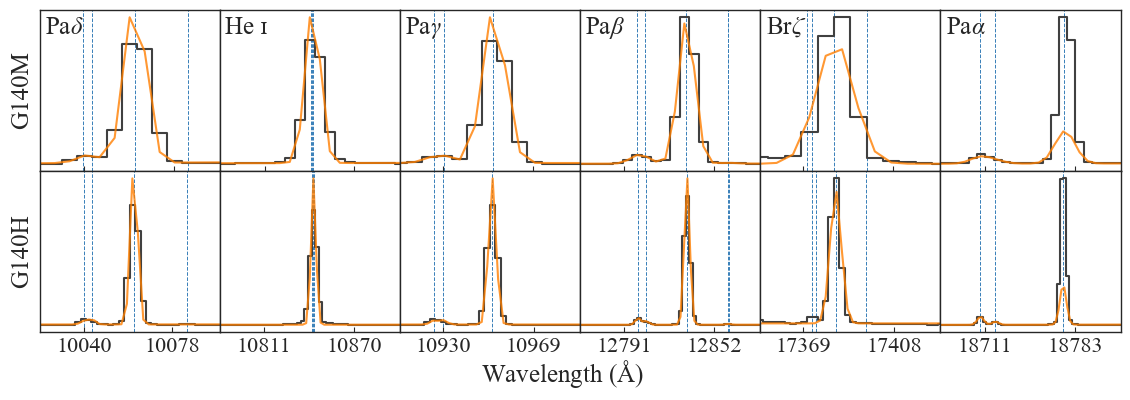

In [11]:
likelihood(
    {
        "velocity_m": 285,
        "R_m": 120,
        "alpha_m": 0,
        "velocity_h": 278,
        "R_h": 40,
        "alpha_h": 0,
        # "pn_sigma": 6.91,
    },
    plot=True,
)

In [12]:
from nautilus import Sampler

sampler = Sampler(
    prior,
    likelihood,
    n_live=3000,
)  # , pass_dict=False) #, pool=8)
sampler.run(verbose=True, discard_exploration=True)

Starting the nautilus sampler...
Please report issues at github.com/johannesulf/nautilus.
Status    | Bounds | Ellipses | Networks | Calls    | f_live | N_eff | log Z    
Finished  | 73     | 1        | 4        | 245500   | N/A    | 10093 | -468751.5


np.True_

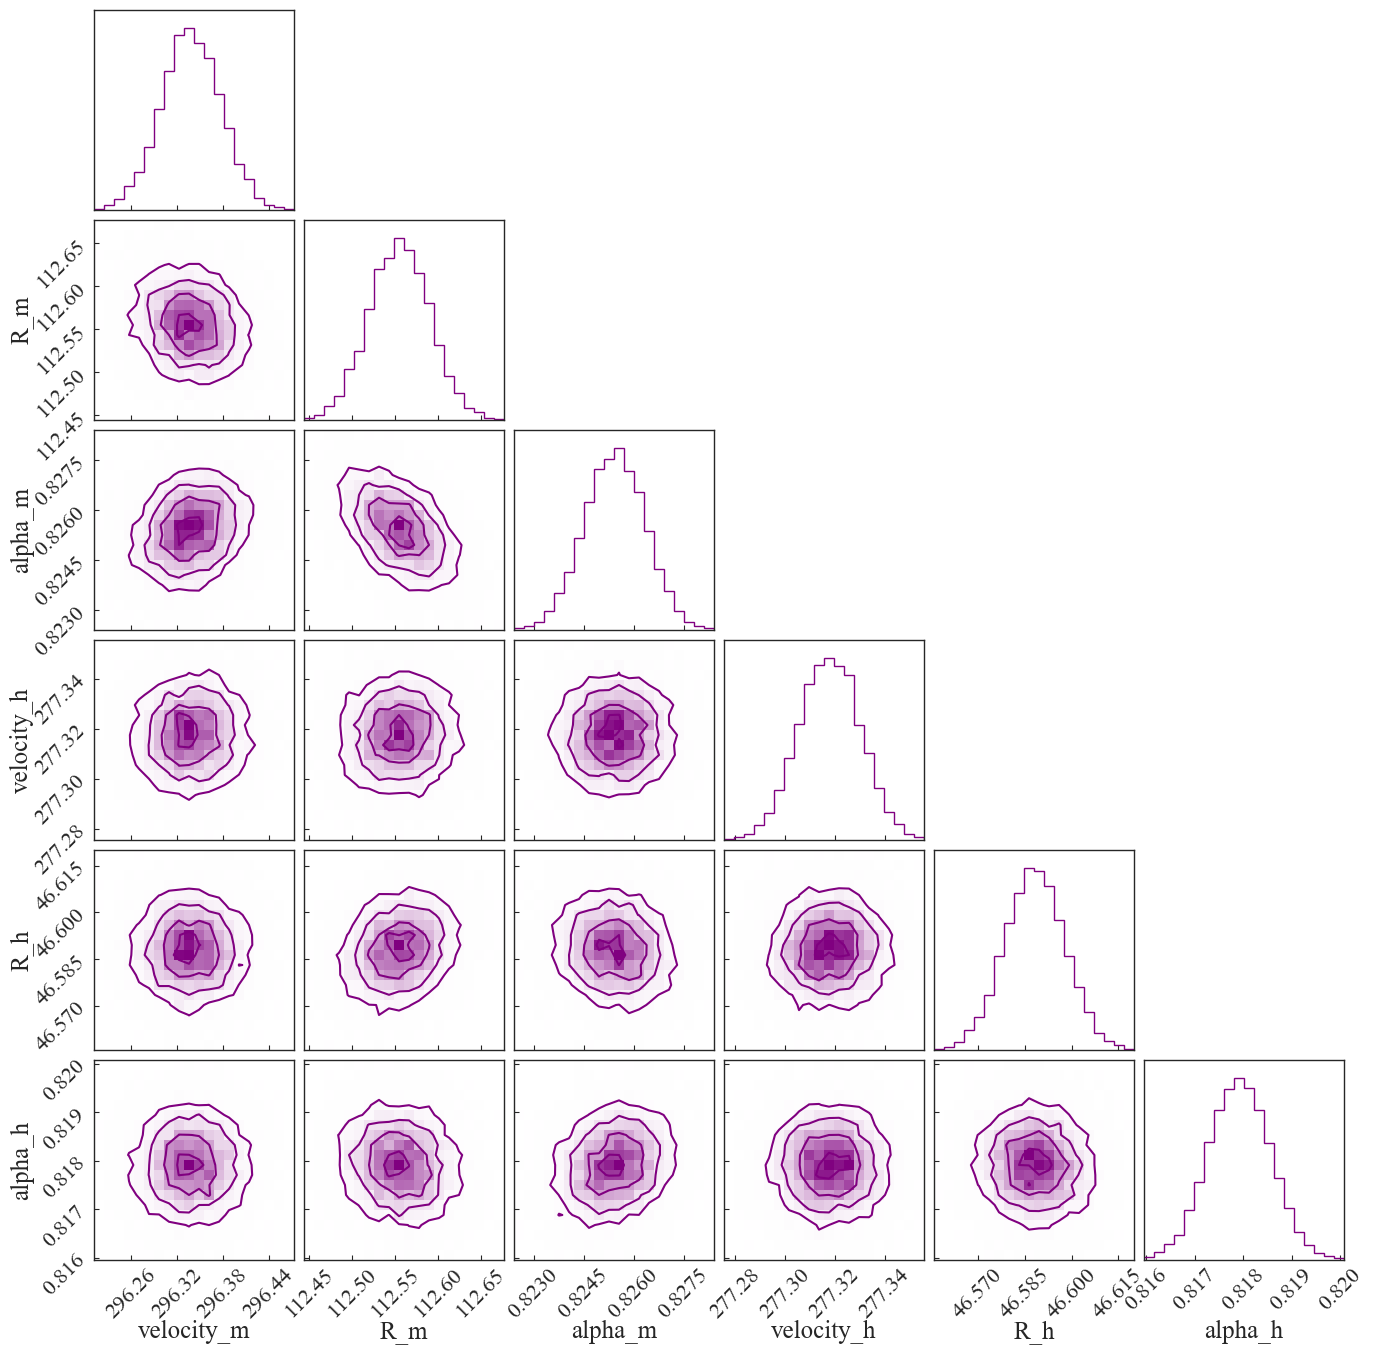

In [15]:
import corner

points, log_w, log_l = sampler.posterior()
# samples = sampler.get_chain(flat=True, discard=100)

corner.corner(
    points,
    weights=np.exp(log_w),
    bins=20,
    labels=prior.keys,
    color="purple",
    plot_datapoints=False,
    range=np.repeat(0.999, len(prior.keys)),
)
plt.show()

Log likelihood: -468709.40350926406


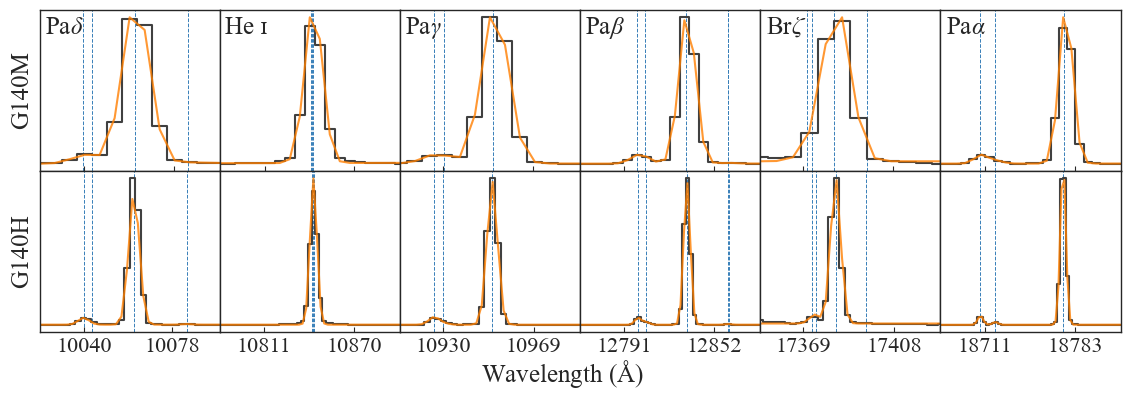

In [16]:
best_fit_params = points[np.argmax(log_w)]

fig, axes = likelihood(
    {
        "velocity_m": best_fit_params[0],
        "R_m": best_fit_params[1],
        "alpha_m": best_fit_params[2],
        "velocity_h": best_fit_params[3],
        "R_h": best_fit_params[4],
        "alpha_h": best_fit_params[5],
        # "pn_sigma": best_fit_params[6],
    },
    plot=True,
)

# fig.savefig(
#     "/Users/ajshajib/Dropbox/papers_proposals/jwst_lsf/f1.pdf", bbox_inches="tight"
# )

In [17]:
if save_output:
    with open(
        f"samplers/sampler_{disperser.upper()}_{filter.upper()}_{mode.upper()}.pkl",
        "wb",
    ) as f:
        output = {
            "points": points,
            "log_w": log_w,
            "lambda_pivot": lambda_pivot,
            "wavelengths": nonzero_wavelengths,
        }
        pickle.dump(output, f)

In [18]:
best_fit_params, lambda_pivot
# uncertainty of best fit params


# Compute weighted percentiles for uncertainties
def weighted_percentile(data, weights, percentiles):
    """
    Compute weighted percentiles.
    """
    data, weights = np.array(data), np.array(weights)
    idx = np.argsort(data)
    data, weights = data[idx], weights[idx]
    cdf = np.cumsum(weights)
    cdf /= cdf[-1]
    return np.interp(percentiles, cdf, data)


param_names = ["velocity_m", "R_m", "alpha_m", "velocity_h", "R_h", "alpha_h"]
weights = np.exp(log_w - np.max(log_w))  # for numerical stability

uncertainty = {}
medians = {}
for i, name in enumerate(param_names):
    median = weighted_percentile(points[:, i], weights, [0.5])[0]
    low = weighted_percentile(points[:, i], weights, [0.16])[0]
    high = weighted_percentile(points[:, i], weights, [0.84])[0]
    uncertainty[name] = 0.5 * (high - low)
    medians[name] = median

# uncertainty["pn_sigma"] = (
#     weighted_percentile(points[:, 6], weights, [0.84])[0]
#     - weighted_percentile(points[:, 6], weights, [0.16])[0]
# )

print("Best fit parameters:")
for i, key in enumerate(param_names):
    print(f"{key}: {best_fit_params[i]:.2f} +/- {uncertainty[key]:.2f}")
    print(f"Median {key}: {medians[key]:.2f} +/- {uncertainty[key]:.2f}")
# print(f"pn_sigma: {best_fit_params[6]:.8f} +/- {uncertainty['pn_sigma']:.8f}")

print("\nUncertainties:")
print(uncertainty)
print(lambda_pivot)

Best fit parameters:
velocity_m: 296.39 +/- 0.04
Median velocity_m: 296.34 +/- 0.04
R_m: 112.61 +/- 0.03
Median R_m: 112.56 +/- 0.03
alpha_m: 0.83 +/- 0.00
Median alpha_m: 0.83 +/- 0.00
velocity_h: 277.31 +/- 0.01
Median velocity_h: 277.32 +/- 0.01
R_h: 46.58 +/- 0.01
Median R_h: 46.59 +/- 0.01
alpha_h: 0.82 +/- 0.00
Median alpha_h: 0.82 +/- 0.00

Uncertainties:
{'velocity_m': np.float64(0.038682197770299354), 'R_m': np.float64(0.03495071674058181), 'alpha_m': np.float64(0.000911233718602189), 'velocity_h': np.float64(0.012223084265315265), 'R_h': np.float64(0.009625563593704811), 'alpha_h': np.float64(0.0006394341203077025)}
13539.588034783763


In [19]:
# caculate R at z = 0.259 and z = 0.654
def calculate_R(z, R_0, alpha):
    lam = 8570 * (1 + z)
    return R_0 + alpha * (lam - lambda_pivot) / 1e4


ca_triplet_wavelengths = [
    8498,
    8542,
    8662,
]  # in AA, from https://linelist.pa.uky.edu/newpage/
mean_ca_triplet_wavelength = 8570  # np.mean(ca_triplet_wavelengths)

z_0 = 0.295
z_1 = 0.654
R_m_0 = calculate_R(z_0, medians["R_m"], medians["alpha_m"])
R_m_1 = calculate_R(z_1, medians["R_m"], medians["alpha_m"])

fwhm0 = mean_ca_triplet_wavelength * (1 + z_0) / R_m_0
fwhm1 = mean_ca_triplet_wavelength * (1 + z_1) / R_m_1

print(f"FWHM at z = {z_0}: {fwhm0:.2f} AA")
print(f"FWHM at z = {z_1}: {fwhm1:.2f} AA")

# uncertainty on fwhm0
samples_R = calculate_R(
    z_0,
    np.random.normal(medians["R_m"], uncertainty["R_m"], 10000),
    np.random.normal(medians["alpha_m"], uncertainty["alpha_m"], 10000),
)  # R at z = 0.295 for all samples
fwhm0_samples = mean_ca_triplet_wavelength * (1 + z_0) / samples_R
fwhm0_low, fwhm0_high = np.percentile(fwhm0_samples, [16, 84])
print(
    f"FWHM at z = {z_0} with uncertainty: {fwhm0:.3f} +- {np.std(fwhm0_samples):.3f} AA"
)

# uncertainty on fwhm1
samples_R = calculate_R(
    z_1,
    np.random.normal(medians["R_m"], uncertainty["R_m"], 10000),
    np.random.normal(medians["alpha_m"], uncertainty["alpha_m"], 10000),
)  # R at z = 0.654 for all samples
fwhm1_samples = mean_ca_triplet_wavelength * (1 + z_1) / samples_R
fwhm1_low, fwhm1_high = np.percentile(fwhm1_samples, [16, 84])
print(
    f"FWHM at z = {z_1} with uncertainty: {fwhm1:.3f} +- {np.std(fwhm1_samples):.3f} AA"
)

print(
    np.mean(fwhm0_samples) / (8570 * (1 + z_0)) * 299752.458 / 2.355,
    np.std(fwhm0_samples) / (8570 * (1 + z_0)) * 299752.458 / 2.355,
)
print(
    np.mean(fwhm1_samples) / (8570 * (1 + z_1)) * 299752.458 / 2.355,
    np.std(fwhm1_samples) / (8570 * (1 + z_1)) * 299752.458 / 2.355,
)

FWHM at z = 0.295: 98.78 AA
FWHM at z = 0.654: 125.88 AA
FWHM at z = 0.295 with uncertainty: 98.779 +- 0.030 AA
FWHM at z = 0.654 with uncertainty: 125.878 +- 0.039 AA
1132.8789972129757 0.34924574687668203
1130.3263356836874 0.34963789881798835


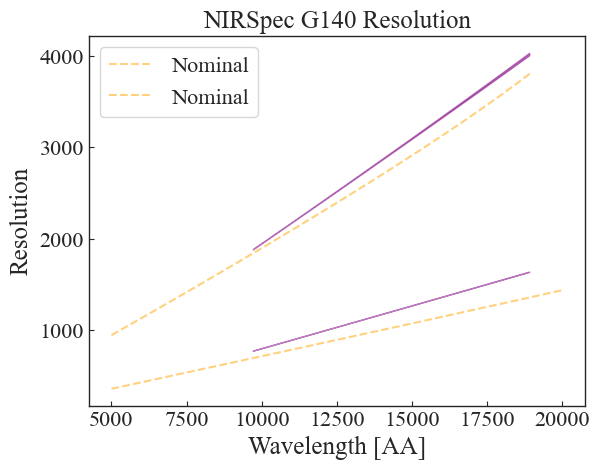

In [20]:
# plot the best fit line

best_fit_params = points[np.argmax(log_w)]

mid_res_params = best_fit_params[1:3]
hi_res_params = best_fit_params[4:]

best_fit_params_both = [mid_res_params, hi_res_params]

for j in range(2):
    res_string = ["M", "H"][j]

    resolution = get_resolution(
        nonzero_wavelengths,
        best_fit_params_both[j],
    )

    N = 1000
    resolution_samples = np.zeros((N, len(nonzero_wavelengths)))
    for i in range(N):
        coeffs = points[
            np.random.choice(len(points), p=np.exp(log_w) / np.sum(np.exp(log_w)))
        ]
        if j == 0:
            coeff = coeffs[1:3]
        else:
            coeff = coeffs[4:6]

        coeffs[0] = np.sqrt(
            coeff[0] ** 2 - np.random.normal(pn_sigma_mean, pn_sigma_sigma) ** 2
        )

        sigma_inst = get_sigma_inst(
            nonzero_wavelengths,
            coeff,
        )
        resolution_samples[i] = (
            light_speed
            / np.sqrt(
                sigma_inst**2 - np.random.normal(pn_sigma_mean, pn_sigma_sigma) ** 2
            )
            / 2.355
        )
        # if add_fwhm_scatter:
        #     resolution_samples[i] += coeffs[3 + i]
        # (
        #     params[1]
        #     + params[2] * (plot_wavelengths - lambda_pivot) / 1e4
        #     + 10 ** (params[3] * (plot_wavelengths - lambda_pivot) / 1e4)
        # )

    # plt.plot(
    #     wavelengths,
    #     resolution,
    #     color="purple",
    #     label="Best fit",
    # )

    plt.fill_between(
        nonzero_wavelengths,
        np.percentile(resolution_samples, 16, axis=0),
        np.percentile(resolution_samples, 84, axis=0),
        color="purple",
        alpha=0.5,
    )

    nominal = fits.getdata(f"data/jwst/jwst_nirspec_{disperser}{res_string}_disp.fits")

    nominal = np.array([tuple(row) for row in nominal])

    # Extract the wavelength and sensitivity values
    nominal_wavelength = nominal[:, 0] * 1e4
    nominal_resolution = nominal[:, 2]

    plt.plot(
        nominal_wavelength,
        nominal_resolution,
        color="orange",
        label="Nominal",
        linestyle="--",
        alpha=0.5,
    )

    # plt.xlim(10000, 20000)
    # plt.ylim(0, 4000)
    plt.xlabel("Wavelength [AA]")
    plt.ylabel("Resolution")
    # plt.yscale("log")
    plt.title(f"NIRSpec {disperser.upper()} Resolution")
    plt.legend()